## Пример работы с моделью SARIMAX

In [1]:
!pip install pmdarima
!pip install statsmodels==0.13.2 

In [2]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.3)

### 1. Работа с данными
Загружаем встроенный в `statsmodels` датасет `CO2 в атмосфере из образцов воздуха в обсерватории Мауна-Лоа, Гавайи, США`, с марта 1958 года по декабрь 2001 года. 

In [3]:
data = sm.datasets.co2.load_pandas()
y = data.data

Начало ряда

In [4]:
y.head(10)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


*Хвост* ряда

In [5]:
y.tail()

,co2
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3
2001-12-29,371.5


Еженедельные данные обрабатывать сложно, поэтому будем использовать месячные средние. 

Обработку сделаем с помощью функции `resample`. Пропуски в данных уберем при помощи функции `fillna` по предыдущим значениям (метод `ffill`).

In [6]:
y = y['co2'].resample('MS').mean()
y = y.fillna(method='ffill')
print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    317.433333
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


Изобразим ряд на графике

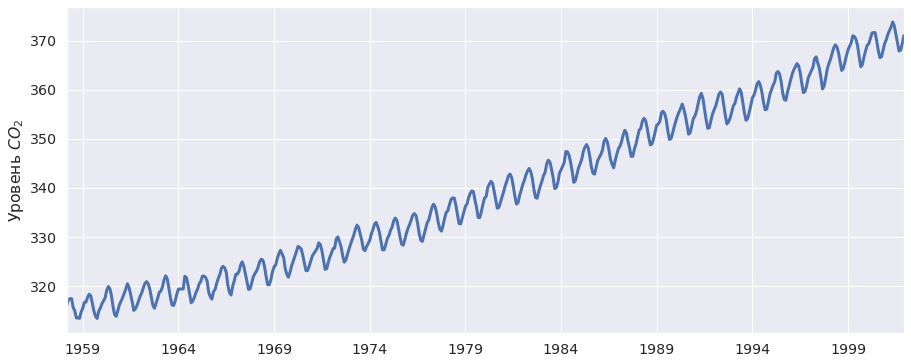

In [7]:
y.plot(figsize=(15, 6), lw=3)
plt.ylabel('Уровень $CO_2$')
plt.show()

### 2. Анализ ряда

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

Частичная автокорреляция - это корреляция значения ряда после снятия с него линейной зависимости от предыдущих значений ряда.

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">`statsmodels.graphics.tsaplots.plot_acf`</a>`(x, ax=None, lags=None, alpha=0.05, use_vlines=True, unbiased=False, fft=False, title='Autocorrelation', zero=True, **kwargs)`

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html">`statsmodels.graphics.tsaplots.plot_pacf`</a>`(x, ax=None, lags=None, alpha=0.05, method='ywm', use_vlines=True, title='Partial Autocorrelation', zero=True, **kwargs)`

* `x` &mdash; временной ряд;
* `lags` &mdash; набор лагов в виде списка или число &mdash; количество лагов (используется `np.arange(lags)`);
* `ax` &mdash; фигура `matplotlib`;
* `alpha` &mdash; уровень доверия для доверительных интервалов.

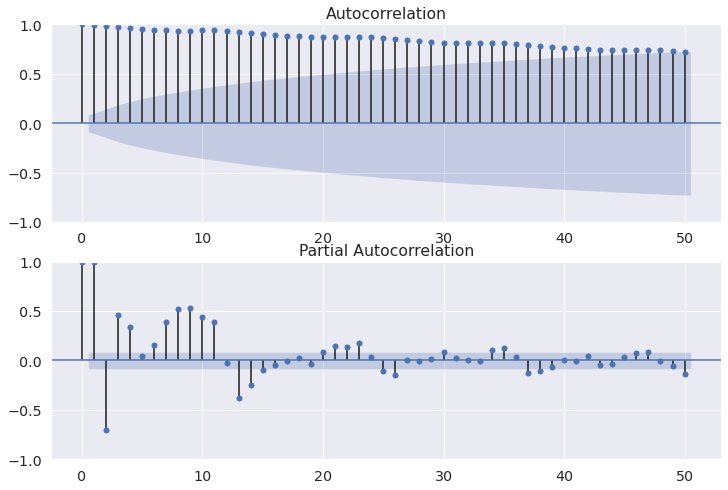

In [27]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=50, ax=ax2, method="ols")
plt.show()

В данных явно есть линейный тренд, что видно по большим значеням автокорреляции. Иначе говоря, чем больше CO2 было в 1980 году, тем больше их будет в 1990. И наоборот.

Продифференцируем ряд и изобразим график полученного ряда.

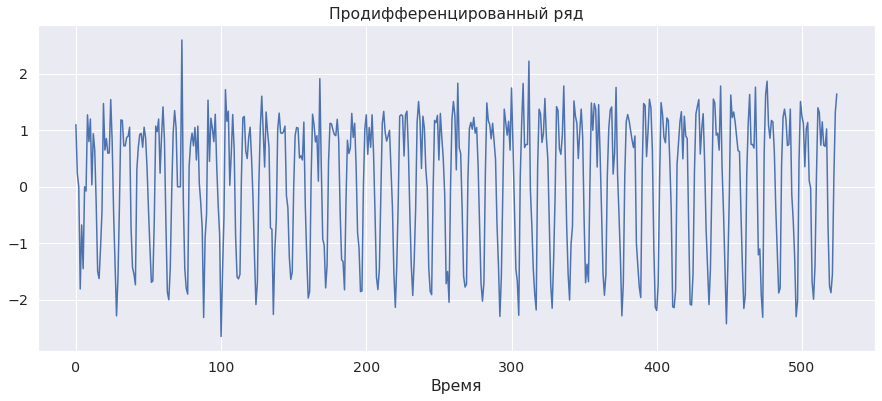

In [28]:
ya = np.array(y)
yt = ya[1:] - ya[:-1]  # дифференцирование

plt.figure(figsize=(15, 6))
plt.plot(yt)
plt.xlabel('Время')
plt.title('Продифференцированный ряд')
plt.show()

Отлично, тренд сняли.

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) для продифференцированного ряда.

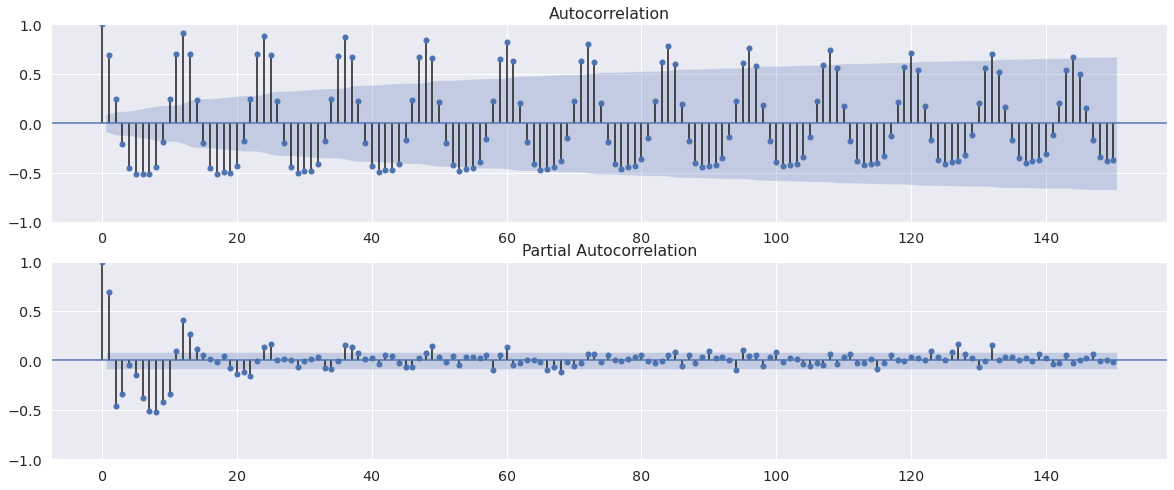

In [29]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(yt, lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(yt, lags=150, ax=ax2, method="ols")
plt.ylim((-1, 1))
plt.show()

Как график продифференцированного ряда, так и его автокорреляционная функция намекают на сезонность. По графику автокорреляций, мы видим положительные пики при значениях лага, кратных 12. Максимальное значение автокорреляции имеет 12-й лаг. Это означает, что чем больше значение ряда было 12 месяцем назад, тем больше оно должно быть сейчас. Наоборот, чем больше значение ряда было 6 месяцев назад, тем меньше оно должно быть сейчас.

Ряд с сезонностью не является стационарным, т.к. распределение ряда меняется в зависимости от сезона. 

Применим дополнительно к нашему ряду еще сезонное дифференцирование.
Период сезонности известен заранее &mdash; 12 месяцев.

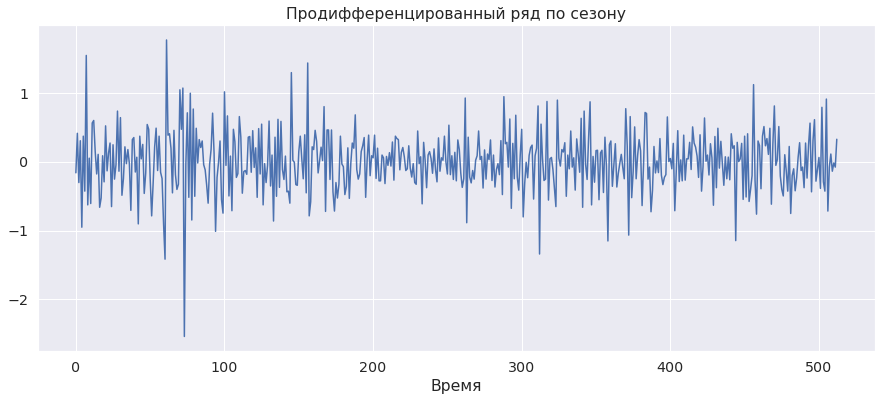

In [19]:
yts = yt[12:] - yt[:-12]

plt.figure(figsize=(15, 6))
plt.plot(yts)
plt.xlabel('Время')
plt.title('Продифференцированный ряд по сезону')
plt.show()

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) после первого дифференцирования и последующего сезонного дифференцирования.

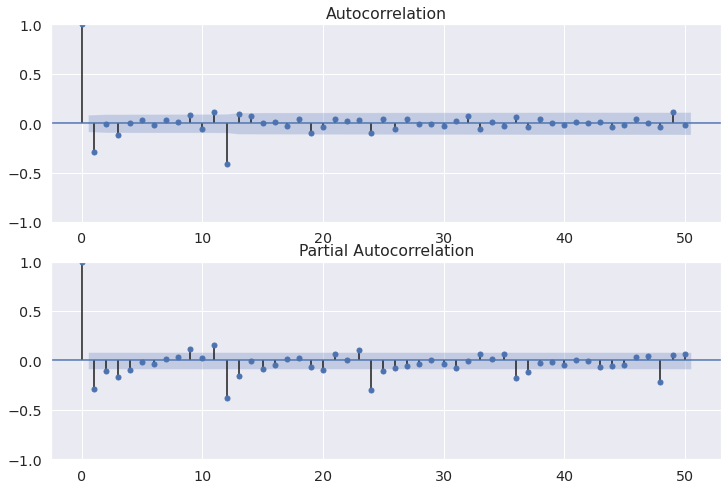

In [22]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(yts, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(yts, lags=50, ax=ax2, method="ols")
plt.show()

По графикам видно несколько значимых лагов в начале, а так же значимые лаги через периоды сезонности. 

Разберем график автокорреляций. По графику видим, что значимыми являются лаги 1 и 3. Это означает, что в формуле для $y_t$ скорее всего с ненулевыми коэффициентами присутствуют значения $y_{t-1}$ и $y_{t-3}$. Поэтому в качестве начального значения для $p$ можно взять $p=3$. 

Отдельно посмотрим на 12-й лаг, который соответствует периоду сезонности, пояснив, почему не стоит обращать на него внимание при выборе $p$. Мы строили коррелограмму для ряда разностей значений в моменты времени $t$ и $t-12$. Такая разность могла "снять" не всю сезонность. В модели SARIMA значение в момент времени $t-12$ учитывается с некоторым коэффициентом, который мы включим в модель с помощью сезонной компоненты. Значения 12, 24 и т.д. лагов могут помочь при выборе начального значения для $P$. Также для выбора этого значения стоит смотреть на коррелограмму ряда до сезонной дифференцирования.

Разберем график частичных автокорреляций. По определению частичная автокорреляция это корреляция значения ряда после снятия с него линейной зависимости от предыдущих значений ряда. В идеале такое снятие линейной зависимости означает, что в формуле для $y_t$ не должно остаться предыдущих значений ряда. Это означает, что в ней остается только линейная комбинация шума. Как раз таки корреляцию с ним мы и рассмотрим.

На графике частичных автокорреляций мы видим, что имеются значимые 1-4 лаги. Поэтому в качестве начальных значений $q$ можно взять 4 или же 3 (т.к. 4-ая близка к незначимой). По сезонным лагам можно подобрать начальное значение для $Q$.

### 3. Выбор модели

Сделаем полный перебор по сетке вокруг начальных значений параметров. Зададим сетку:

In [ ]:
p = range(4)
q = range(1, 5)
d = [1]
P = range(3, 8)
D = [1]
Q = range(1, 6)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) 
                for x in list(itertools.product(P, D, Q))]

Класс, реализующий модель SARIMAX$(p, d, q) \times (P, D, Q)_s$

`class` <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">`statsmodels.tsa.statespace.sarimax.SARIMAX`</a>`(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, **kwargs)`

Параметры:

* `endog` &mdash; временной ряд;
* `exog` &mdash; экзогенные факторы (регрессоры);
* `order` = гиперпараметы $(p, d, q)$ модели ARIMA;
* `seasonal_order` = сезонные гиперпараметры $(P, D, Q, s)$
* `trend` &mdash; тренд по времени. Например, если `trend=[1,1,0,1]`, то модель содержит $a + bt + ct^3$. По умолчанию тренд не используется;
* `enforce_stationarity` &mdash; требовать ли стационарность AR компоненты. Если нет, то AR-составляющая модели может задавать нестационарный ряд. Если да, то модель может не подобраться;
* `enforce_invertibility ` &mdash; требовать ли обратимость MA компоненты.

Атрибуты построенной модели:

* `polynomial_ar` &mdash; коэффициенты AR-составляющей;
* `polynomial_ma` &mdash; коэффициенты MA-составляющей;
* `polynomial_seasonal_ar` &mdash; коэффициенты сезонной AR-составляющей;
* `polynomial_seasonal_ma` &mdash; коэффициенты сезонной MA-составляющей;
* `polynomial_trend` &mdash; коэффициенты тренда по времени;
* и другие.

In [ ]:
best_aic = np.inf
best_params = None

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = sm.tsa.statespace.SARIMAX(
                y, order=param, seasonal_order=param_seasonal, 
                # не будем требовать жесткие теоретические условия
                enforce_stationarity=False, enforce_invertibility=False
            )
            model = model.fit()
            print('ARIMA{}x{} – AIC: {:.2f}'.format(param, param_seasonal, 
                                                    model.aic))
            
            # Если нашли более подходящую модель
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = param, param_seasonal
                
        except:
            # Если модель построить не получится, то она выдаст исключение
            continue

ARIMA(0, 1, 1)x(3, 1, 1, 12) – AIC: 274.76
ARIMA(0, 1, 1)x(3, 1, 2, 12) – AIC: 280.21
ARIMA(0, 1, 1)x(3, 1, 3, 12) – AIC: 255.83
ARIMA(0, 1, 1)x(3, 1, 4, 12) – AIC: 253.08


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(3, 1, 5, 12) – AIC: 208.16
ARIMA(0, 1, 1)x(4, 1, 1, 12) – AIC: 281.29
ARIMA(0, 1, 1)x(4, 1, 2, 12) – AIC: 279.23
ARIMA(0, 1, 1)x(4, 1, 3, 12) – AIC: 241.79


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(4, 1, 4, 12) – AIC: 245.93


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(4, 1, 5, 12) – AIC: 202.02
ARIMA(0, 1, 1)x(5, 1, 1, 12) – AIC: 271.03
ARIMA(0, 1, 1)x(5, 1, 2, 12) – AIC: 270.28
ARIMA(0, 1, 1)x(5, 1, 3, 12) – AIC: 233.40


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(5, 1, 4, 12) – AIC: 233.12


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(5, 1, 5, 12) – AIC: 207.04
ARIMA(0, 1, 1)x(6, 1, 1, 12) – AIC: 222.50
ARIMA(0, 1, 1)x(6, 1, 2, 12) – AIC: 220.72
ARIMA(0, 1, 1)x(6, 1, 3, 12) – AIC: 216.79
ARIMA(0, 1, 1)x(6, 1, 4, 12) – AIC: 209.03


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(6, 1, 5, 12) – AIC: 200.55
ARIMA(0, 1, 1)x(7, 1, 1, 12) – AIC: 190.57


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(7, 1, 2, 12) – AIC: 192.27
ARIMA(0, 1, 1)x(7, 1, 3, 12) – AIC: 183.73
ARIMA(0, 1, 1)x(7, 1, 4, 12) – AIC: 184.59
ARIMA(0, 1, 1)x(7, 1, 5, 12) – AIC: 185.66


ARIMA(0, 1, 2)x(3, 1, 1, 12) – AIC: 272.35
ARIMA(0, 1, 2)x(3, 1, 2, 12) – AIC: 277.74
ARIMA(0, 1, 2)x(3, 1, 3, 12) – AIC: 254.07
ARIMA(0, 1, 2)x(3, 1, 4, 12) – AIC: 246.72
ARIMA(0, 1, 2)x(3, 1, 5, 12) – AIC: 199.99
ARIMA(0, 1, 2)x(4, 1, 1, 12) – AIC: 279.49
ARIMA(0, 1, 2)x(4, 1, 2, 12) – AIC: 278.12
ARIMA(0, 1, 2)x(4, 1, 3, 12) – AIC: 241.06
ARIMA(0, 1, 2)x(4, 1, 4, 12) – AIC: 241.27


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(4, 1, 5, 12) – AIC: 201.87
ARIMA(0, 1, 2)x(5, 1, 1, 12) – AIC: 271.23
ARIMA(0, 1, 2)x(5, 1, 2, 12) – AIC: 270.62


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(5, 1, 3, 12) – AIC: 231.24


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(5, 1, 4, 12) – AIC: 235.37


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(5, 1, 5, 12) – AIC: 200.60
ARIMA(0, 1, 2)x(6, 1, 1, 12) – AIC: 224.01
ARIMA(0, 1, 2)x(6, 1, 2, 12) – AIC: 222.32
ARIMA(0, 1, 2)x(6, 1, 3, 12) – AIC: 218.67


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(6, 1, 4, 12) – AIC: 210.76


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(6, 1, 5, 12) – AIC: 202.49
ARIMA(0, 1, 2)x(7, 1, 1, 12) – AIC: 191.55
ARIMA(0, 1, 2)x(7, 1, 2, 12) – AIC: 193.23
ARIMA(0, 1, 2)x(7, 1, 3, 12) – AIC: 184.97
ARIMA(0, 1, 2)x(7, 1, 4, 12) – AIC: 185.98
ARIMA(0, 1, 2)x(7, 1, 5, 12) – AIC: 187.05


ARIMA(0, 1, 3)x(3, 1, 1, 12) – AIC: 272.68
ARIMA(0, 1, 3)x(3, 1, 2, 12) – AIC: 278.11
ARIMA(0, 1, 3)x(3, 1, 3, 12) – AIC: 254.50
ARIMA(0, 1, 3)x(3, 1, 4, 12) – AIC: 245.89
ARIMA(0, 1, 3)x(3, 1, 5, 12) – AIC: 202.28
ARIMA(0, 1, 3)x(4, 1, 1, 12) – AIC: 279.74
ARIMA(0, 1, 3)x(4, 1, 2, 12) – AIC: 278.74
ARIMA(0, 1, 3)x(4, 1, 3, 12) – AIC: 242.10
ARIMA(0, 1, 3)x(4, 1, 4, 12) – AIC: 240.26


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 3)x(4, 1, 5, 12) – AIC: 199.64
ARIMA(0, 1, 3)x(5, 1, 1, 12) – AIC: 272.42
ARIMA(0, 1, 3)x(5, 1, 2, 12) – AIC: 271.91
ARIMA(0, 1, 3)x(5, 1, 3, 12) – AIC: 236.50
ARIMA(0, 1, 3)x(5, 1, 4, 12) – AIC: 236.66


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 3)x(5, 1, 5, 12) – AIC: 200.79
ARIMA(0, 1, 3)x(6, 1, 1, 12) – AIC: 226.00
ARIMA(0, 1, 3)x(6, 1, 2, 12) – AIC: 224.32
ARIMA(0, 1, 3)x(6, 1, 3, 12) – AIC: 220.58
ARIMA(0, 1, 3)x(6, 1, 4, 12) – AIC: 212.75
ARIMA(0, 1, 3)x(6, 1, 5, 12) – AIC: 204.32
ARIMA(0, 1, 3)x(7, 1, 1, 12) – AIC: 193.41
ARIMA(0, 1, 3)x(7, 1, 2, 12) – AIC: 195.05
ARIMA(0, 1, 3)x(7, 1, 3, 12) – AIC: 186.92
ARIMA(0, 1, 3)x(7, 1, 4, 12) – AIC: 187.94
ARIMA(0, 1, 3)x(7, 1, 5, 12) – AIC: 189.02


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(3, 1, 1, 12) – AIC: 274.68
ARIMA(0, 1, 4)x(3, 1, 2, 12) – AIC: 280.11
ARIMA(0, 1, 4)x(3, 1, 3, 12) – AIC: 256.67
ARIMA(0, 1, 4)x(3, 1, 4, 12) – AIC: 246.95


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(3, 1, 5, 12) – AIC: 205.66
ARIMA(0, 1, 4)x(4, 1, 1, 12) – AIC: 281.73
ARIMA(0, 1, 4)x(4, 1, 2, 12) – AIC: 280.57
ARIMA(0, 1, 4)x(4, 1, 3, 12) – AIC: 243.90


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(4, 1, 4, 12) – AIC: 242.07


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(4, 1, 5, 12) – AIC: 201.83
ARIMA(0, 1, 4)x(5, 1, 1, 12) – AIC: 274.40
ARIMA(0, 1, 4)x(5, 1, 2, 12) – AIC: 273.86


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(5, 1, 3, 12) – AIC: 234.22


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(5, 1, 4, 12) – AIC: 235.68


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(5, 1, 5, 12) – AIC: 205.34
ARIMA(0, 1, 4)x(6, 1, 1, 12) – AIC: 228.00
ARIMA(0, 1, 4)x(6, 1, 2, 12) – AIC: 226.32


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(6, 1, 3, 12) – AIC: 222.20


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(6, 1, 4, 12) – AIC: 214.71


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(6, 1, 5, 12) – AIC: 206.30
ARIMA(0, 1, 4)x(7, 1, 1, 12) – AIC: 195.13
ARIMA(0, 1, 4)x(7, 1, 2, 12) – AIC: 196.78
ARIMA(0, 1, 4)x(7, 1, 3, 12) – AIC: 188.69
ARIMA(0, 1, 4)x(7, 1, 4, 12) – AIC: 189.74


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 4)x(7, 1, 5, 12) – AIC: 190.81


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(3, 1, 1, 12) – AIC: 271.61
ARIMA(1, 1, 1)x(3, 1, 2, 12) – AIC: 276.25
ARIMA(1, 1, 1)x(3, 1, 3, 12) – AIC: 253.30


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(3, 1, 4, 12) – AIC: 250.86


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(3, 1, 5, 12) – AIC: 205.71
ARIMA(1, 1, 1)x(4, 1, 1, 12) – AIC: 277.10
ARIMA(1, 1, 1)x(4, 1, 2, 12) – AIC: 275.80
ARIMA(1, 1, 1)x(4, 1, 3, 12) – AIC: 240.30
ARIMA(1, 1, 1)x(4, 1, 4, 12) – AIC: 240.64


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(4, 1, 5, 12) – AIC: 206.39
ARIMA(1, 1, 1)x(5, 1, 1, 12) – AIC: 259.30
ARIMA(1, 1, 1)x(5, 1, 2, 12) – AIC: 259.94
ARIMA(1, 1, 1)x(5, 1, 3, 12) – AIC: 224.81


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(5, 1, 4, 12) – AIC: 218.95


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(5, 1, 5, 12) – AIC: 204.55
ARIMA(1, 1, 1)x(6, 1, 1, 12) – AIC: 224.36
ARIMA(1, 1, 1)x(6, 1, 2, 12) – AIC: 222.58
ARIMA(1, 1, 1)x(6, 1, 3, 12) – AIC: 212.80


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(6, 1, 4, 12) – AIC: 211.02


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(6, 1, 5, 12) – AIC: 200.32
ARIMA(1, 1, 1)x(7, 1, 1, 12) – AIC: 191.40
ARIMA(1, 1, 1)x(7, 1, 2, 12) – AIC: 192.80
ARIMA(1, 1, 1)x(7, 1, 3, 12) – AIC: 185.13
ARIMA(1, 1, 1)x(7, 1, 4, 12) – AIC: 186.26


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(7, 1, 5, 12) – AIC: 187.27


ARIMA(1, 1, 2)x(3, 1, 1, 12) – AIC: 273.33
ARIMA(1, 1, 2)x(3, 1, 2, 12) – AIC: 278.14
ARIMA(1, 1, 2)x(3, 1, 3, 12) – AIC: 255.25


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(3, 1, 4, 12) – AIC: 248.42


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(3, 1, 5, 12) – AIC: 201.82
ARIMA(1, 1, 2)x(4, 1, 1, 12) – AIC: 278.93
ARIMA(1, 1, 2)x(4, 1, 2, 12) – AIC: 277.56
ARIMA(1, 1, 2)x(4, 1, 3, 12) – AIC: 242.01


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(4, 1, 4, 12) – AIC: 246.05


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(4, 1, 5, 12) – AIC: 201.81
ARIMA(1, 1, 2)x(5, 1, 1, 12) – AIC: 261.15
ARIMA(1, 1, 2)x(5, 1, 2, 12) – AIC: 261.82


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(5, 1, 3, 12) – AIC: 217.62


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(5, 1, 4, 12) – AIC: 220.07
ARIMA(1, 1, 2)x(5, 1, 5, 12) – AIC: 206.82
ARIMA(1, 1, 2)x(6, 1, 1, 12) – AIC: 226.35
ARIMA(1, 1, 2)x(6, 1, 2, 12) – AIC: 224.59


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(6, 1, 3, 12) – AIC: 214.52
ARIMA(1, 1, 2)x(6, 1, 4, 12) – AIC: 213.02


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(6, 1, 5, 12) – AIC: 202.31
ARIMA(1, 1, 2)x(7, 1, 1, 12) – AIC: 193.20


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(7, 1, 2, 12) – AIC: 193.50


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(7, 1, 3, 12) – AIC: 186.93


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(7, 1, 4, 12) – AIC: 188.02


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(7, 1, 5, 12) – AIC: 189.21


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(3, 1, 1, 12) – AIC: 274.42
ARIMA(1, 1, 3)x(3, 1, 2, 12) – AIC: 279.74


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(3, 1, 3, 12) – AIC: 256.49


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(3, 1, 4, 12) – AIC: 247.72


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(3, 1, 5, 12) – AIC: 201.42
ARIMA(1, 1, 3)x(4, 1, 1, 12) – AIC: 280.46


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(4, 1, 2, 12) – AIC: 279.12


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(4, 1, 3, 12) – AIC: 243.95


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(4, 1, 4, 12) – AIC: 242.11


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(4, 1, 5, 12) – AIC: 201.78
ARIMA(1, 1, 3)x(5, 1, 1, 12) – AIC: 262.89
ARIMA(1, 1, 3)x(5, 1, 2, 12) – AIC: 263.55


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(5, 1, 3, 12) – AIC: 219.67


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(5, 1, 4, 12) – AIC: 223.65


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(5, 1, 5, 12) – AIC: 202.78
ARIMA(1, 1, 3)x(6, 1, 1, 12) – AIC: 228.36
ARIMA(1, 1, 3)x(6, 1, 2, 12) – AIC: 226.58


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(6, 1, 3, 12) – AIC: 216.45


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(6, 1, 4, 12) – AIC: 215.03


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(6, 1, 5, 12) – AIC: 204.00
ARIMA(1, 1, 3)x(7, 1, 1, 12) – AIC: 195.20


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(7, 1, 2, 12) – AIC: 196.53


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(7, 1, 3, 12) – AIC: 189.10


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(7, 1, 4, 12) – AIC: 190.24


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3)x(7, 1, 5, 12) – AIC: 191.28


ARIMA(1, 1, 4)x(3, 1, 1, 12) – AIC: 276.87
ARIMA(1, 1, 4)x(3, 1, 2, 12) – AIC: 281.70


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(3, 1, 3, 12) – AIC: 257.70


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(3, 1, 4, 12) – AIC: 249.78


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(3, 1, 5, 12) – AIC: 207.40
ARIMA(1, 1, 4)x(4, 1, 1, 12) – AIC: 282.39
ARIMA(1, 1, 4)x(4, 1, 2, 12) – AIC: 281.13


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(4, 1, 3, 12) – AIC: 245.93


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(4, 1, 4, 12) – AIC: 244.07


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(4, 1, 5, 12) – AIC: 209.25
ARIMA(1, 1, 4)x(5, 1, 1, 12) – AIC: 264.85


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(5, 1, 2, 12) – AIC: 265.52


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(5, 1, 3, 12) – AIC: 221.93


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(5, 1, 4, 12) – AIC: 225.41


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(5, 1, 5, 12) – AIC: 204.60
ARIMA(1, 1, 4)x(6, 1, 1, 12) – AIC: 230.34


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(6, 1, 2, 12) – AIC: 228.58


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(6, 1, 3, 12) – AIC: 218.14


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(6, 1, 4, 12) – AIC: 216.92


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(6, 1, 5, 12) – AIC: 205.71


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(7, 1, 1, 12) – AIC: 197.04


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(7, 1, 2, 12) – AIC: 198.41


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(7, 1, 3, 12) – AIC: 190.74


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(7, 1, 4, 12) – AIC: 191.81


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4)x(7, 1, 5, 12) – AIC: 192.88


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(3, 1, 1, 12) – AIC: 271.87
ARIMA(2, 1, 1)x(3, 1, 2, 12) – AIC: 275.40


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(3, 1, 3, 12) – AIC: 261.05


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(3, 1, 4, 12) – AIC: 249.98


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(3, 1, 5, 12) – AIC: 211.00
ARIMA(2, 1, 1)x(4, 1, 1, 12) – AIC: 276.48


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(4, 1, 2, 12) – AIC: 276.51


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(4, 1, 3, 12) – AIC: 241.51


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(4, 1, 4, 12) – AIC: 242.32


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(4, 1, 5, 12) – AIC: 211.40
ARIMA(2, 1, 1)x(5, 1, 1, 12) – AIC: 246.33


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(5, 1, 2, 12) – AIC: 239.27
ARIMA(2, 1, 1)x(5, 1, 3, 12) – AIC: 216.01


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(5, 1, 4, 12) – AIC: 215.47


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(5, 1, 5, 12) – AIC: 204.28


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(6, 1, 1, 12) – AIC: 217.32


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(6, 1, 2, 12) – AIC: 218.92


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(6, 1, 3, 12) – AIC: 200.76


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(6, 1, 4, 12) – AIC: 202.93


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(6, 1, 5, 12) – AIC: 204.06


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(7, 1, 1, 12) – AIC: 193.12


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(7, 1, 2, 12) – AIC: 194.92


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(7, 1, 3, 12) – AIC: 186.03


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(7, 1, 4, 12) – AIC: 187.91


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(7, 1, 5, 12) – AIC: 189.26


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(3, 1, 1, 12) – AIC: 273.39
ARIMA(2, 1, 2)x(3, 1, 2, 12) – AIC: 277.28
ARIMA(2, 1, 2)x(3, 1, 3, 12) – AIC: 255.68


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(3, 1, 4, 12) – AIC: 249.90


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(3, 1, 5, 12) – AIC: 203.63
ARIMA(2, 1, 2)x(4, 1, 1, 12) – AIC: 278.31
ARIMA(2, 1, 2)x(4, 1, 2, 12) – AIC: 278.35


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(4, 1, 3, 12) – AIC: 243.51


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(4, 1, 4, 12) – AIC: 244.22


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(4, 1, 5, 12) – AIC: 204.26
ARIMA(2, 1, 2)x(5, 1, 1, 12) – AIC: 247.06
ARIMA(2, 1, 2)x(5, 1, 2, 12) – AIC: 241.17


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(5, 1, 3, 12) – AIC: 212.28


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(5, 1, 4, 12) – AIC: 212.60


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(5, 1, 5, 12) – AIC: 209.38


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(6, 1, 1, 12) – AIC: 218.69


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(6, 1, 2, 12) – AIC: 220.97


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(6, 1, 3, 12) – AIC: 202.91


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(6, 1, 4, 12) – AIC: 204.59


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(6, 1, 5, 12) – AIC: 206.39


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(7, 1, 1, 12) – AIC: 195.08


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(7, 1, 2, 12) – AIC: 196.89
ARIMA(2, 1, 2)x(7, 1, 3, 12) – AIC: 187.96
ARIMA(2, 1, 2)x(7, 1, 4, 12) – AIC: 189.96


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(7, 1, 5, 12) – AIC: 192.77


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(3, 1, 1, 12) – AIC: 274.91
ARIMA(2, 1, 3)x(3, 1, 2, 12) – AIC: 278.92
ARIMA(2, 1, 3)x(3, 1, 3, 12) – AIC: 258.49


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(3, 1, 4, 12) – AIC: 249.00


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(3, 1, 5, 12) – AIC: 203.62
ARIMA(2, 1, 3)x(4, 1, 1, 12) – AIC: 280.00


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(4, 1, 2, 12) – AIC: 280.07


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(4, 1, 3, 12) – AIC: 245.51


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(4, 1, 4, 12) – AIC: 244.09


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(4, 1, 5, 12) – AIC: 203.68


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(5, 1, 1, 12) – AIC: 248.49


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(5, 1, 2, 12) – AIC: 242.80


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(5, 1, 3, 12) – AIC: 214.56


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(5, 1, 4, 12) – AIC: 213.50


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(5, 1, 5, 12) – AIC: 210.49


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(6, 1, 1, 12) – AIC: 220.63


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(6, 1, 2, 12) – AIC: 222.60


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(6, 1, 3, 12) – AIC: 204.62


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(6, 1, 4, 12) – AIC: 206.78


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(6, 1, 5, 12) – AIC: 208.28
ARIMA(2, 1, 3)x(7, 1, 1, 12) – AIC: 197.07


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(7, 1, 2, 12) – AIC: 198.84


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(7, 1, 3, 12) – AIC: 189.77


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(7, 1, 4, 12) – AIC: 192.13


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3)x(7, 1, 5, 12) – AIC: 193.37


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(3, 1, 1, 12) – AIC: 276.94


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(3, 1, 2, 12) – AIC: 280.93


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(3, 1, 3, 12) – AIC: 260.45


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(3, 1, 4, 12) – AIC: 251.77


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(3, 1, 5, 12) – AIC: 209.43


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(4, 1, 1, 12) – AIC: 281.71


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(4, 1, 2, 12) – AIC: 281.91


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(4, 1, 3, 12) – AIC: 247.40


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(4, 1, 4, 12) – AIC: 245.98


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(4, 1, 5, 12) – AIC: 211.25
ARIMA(2, 1, 4)x(5, 1, 1, 12) – AIC: 248.26


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(5, 1, 2, 12) – AIC: 243.73


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(5, 1, 3, 12) – AIC: 214.94


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(5, 1, 4, 12) – AIC: 216.08


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(5, 1, 5, 12) – AIC: 206.55


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(6, 1, 1, 12) – AIC: 214.93


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(6, 1, 2, 12) – AIC: 224.46


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(6, 1, 3, 12) – AIC: 206.19


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(6, 1, 4, 12) – AIC: 207.89


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(6, 1, 5, 12) – AIC: 209.31


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(7, 1, 1, 12) – AIC: 198.75


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(7, 1, 2, 12) – AIC: 200.58


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(7, 1, 3, 12) – AIC: 191.42


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(7, 1, 4, 12) – AIC: 193.48


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4)x(7, 1, 5, 12) – AIC: 194.79


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(3, 1, 1, 12) – AIC: 274.32
ARIMA(3, 1, 1)x(3, 1, 2, 12) – AIC: 277.22


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(3, 1, 3, 12) – AIC: 257.24


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(3, 1, 4, 12) – AIC: 250.39


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(3, 1, 5, 12) – AIC: 209.41
ARIMA(3, 1, 1)x(4, 1, 1, 12) – AIC: 277.96
ARIMA(3, 1, 1)x(4, 1, 2, 12) – AIC: 278.25


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(4, 1, 3, 12) – AIC: 243.36


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(4, 1, 4, 12) – AIC: 244.13


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(4, 1, 5, 12) – AIC: 205.74
ARIMA(3, 1, 1)x(5, 1, 1, 12) – AIC: 242.36


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(5, 1, 2, 12) – AIC: 236.90


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(5, 1, 3, 12) – AIC: 209.16


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(5, 1, 4, 12) – AIC: 207.84


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(5, 1, 5, 12) – AIC: 204.68
ARIMA(3, 1, 1)x(6, 1, 1, 12) – AIC: 215.87


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(6, 1, 2, 12) – AIC: 217.58


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(6, 1, 3, 12) – AIC: 199.50


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(6, 1, 4, 12) – AIC: 201.24


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(6, 1, 5, 12) – AIC: 202.94
ARIMA(3, 1, 1)x(7, 1, 1, 12) – AIC: 195.30


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(7, 1, 2, 12) – AIC: 197.16


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(7, 1, 3, 12) – AIC: 187.39


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(7, 1, 4, 12) – AIC: 189.53


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(7, 1, 5, 12) – AIC: 191.55


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(3, 1, 1, 12) – AIC: 275.88


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(3, 1, 2, 12) – AIC: 279.17
ARIMA(3, 1, 2)x(3, 1, 3, 12) – AIC: 259.16


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(3, 1, 4, 12) – AIC: 251.94


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(3, 1, 5, 12) – AIC: 205.54
ARIMA(3, 1, 2)x(4, 1, 1, 12) – AIC: 279.86


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(4, 1, 2, 12) – AIC: 280.12
ARIMA(3, 1, 2)x(4, 1, 3, 12) – AIC: 245.37
ARIMA(3, 1, 2)x(4, 1, 4, 12) – AIC: 246.14


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(4, 1, 5, 12) – AIC: 205.31


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(5, 1, 1, 12) – AIC: 244.35


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(5, 1, 2, 12) – AIC: 238.91
ARIMA(3, 1, 2)x(5, 1, 3, 12) – AIC: 210.55


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(5, 1, 4, 12) – AIC: 208.95


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(5, 1, 5, 12) – AIC: 210.64
ARIMA(3, 1, 2)x(6, 1, 1, 12) – AIC: 217.83


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(6, 1, 2, 12) – AIC: 219.53


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(6, 1, 3, 12) – AIC: 201.44


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(6, 1, 4, 12) – AIC: 202.64


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(6, 1, 5, 12) – AIC: 204.18
ARIMA(3, 1, 2)x(7, 1, 1, 12) – AIC: 197.29


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(7, 1, 2, 12) – AIC: 196.32


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(7, 1, 3, 12) – AIC: 189.34


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(7, 1, 4, 12) – AIC: 191.29


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(7, 1, 5, 12) – AIC: 193.02


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(3, 1, 1, 12) – AIC: 277.59


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(3, 1, 2, 12) – AIC: 280.77


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(3, 1, 3, 12) – AIC: 259.41


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(3, 1, 4, 12) – AIC: 249.29


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(3, 1, 5, 12) – AIC: 207.67


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(4, 1, 1, 12) – AIC: 281.76


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(4, 1, 2, 12) – AIC: 282.08


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(4, 1, 3, 12) – AIC: 247.35


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(4, 1, 4, 12) – AIC: 246.07


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(4, 1, 5, 12) – AIC: 205.07


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(5, 1, 1, 12) – AIC: 246.28


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(5, 1, 2, 12) – AIC: 240.79


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(5, 1, 3, 12) – AIC: 212.75


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(5, 1, 4, 12) – AIC: 210.71


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(5, 1, 5, 12) – AIC: 206.62


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(6, 1, 1, 12) – AIC: 219.78


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(6, 1, 2, 12) – AIC: 221.58


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(6, 1, 3, 12) – AIC: 203.33


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(6, 1, 4, 12) – AIC: 204.56


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(6, 1, 5, 12) – AIC: 206.00


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(7, 1, 1, 12) – AIC: 198.99


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(7, 1, 2, 12) – AIC: 201.01


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(7, 1, 3, 12) – AIC: 191.06


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(7, 1, 4, 12) – AIC: 193.14


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3)x(7, 1, 5, 12) – AIC: 194.91


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(3, 1, 1, 12) – AIC: 279.61


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(3, 1, 2, 12) – AIC: 283.01


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(3, 1, 3, 12) – AIC: 257.66


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(3, 1, 4, 12) – AIC: 252.55


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(3, 1, 5, 12) – AIC: 210.20


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(4, 1, 1, 12) – AIC: 283.92


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(4, 1, 2, 12) – AIC: 285.12


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(4, 1, 3, 12) – AIC: 249.41


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(4, 1, 4, 12) – AIC: 248.02


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(4, 1, 5, 12) – AIC: 212.87


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(5, 1, 1, 12) – AIC: 247.71


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(5, 1, 2, 12) – AIC: 242.86
ARIMA(3, 1, 4)x(5, 1, 3, 12) – AIC: 217.36


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(5, 1, 4, 12) – AIC: 214.35


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(5, 1, 5, 12) – AIC: 209.23


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(6, 1, 1, 12) – AIC: 218.64


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(6, 1, 2, 12) – AIC: 223.39


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(6, 1, 3, 12) – AIC: 204.97


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(6, 1, 4, 12) – AIC: 212.26


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(6, 1, 5, 12) – AIC: 206.03


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(7, 1, 1, 12) – AIC: 198.32


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(7, 1, 2, 12) – AIC: 200.53


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(7, 1, 3, 12) – AIC: 191.46


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(7, 1, 4, 12) – AIC: 190.03


/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4)x(7, 1, 5, 12) – AIC: 194.55



Оптимальной является модель

In [ ]:
print('ARIMA{}x{}'.format(param, param_seasonal))

ARIMA(3, 1, 4)x(7, 1, 5, 12)



### 4. Анализ статистических свойств модели

Обучим эту модель и выведем некоторе статистические свойства

In [ ]:
model = sm.tsa.statespace.SARIMAX(
    y, order=(3, 1, 4), seasonal_order=(7, 1, 5, 12),
    enforce_stationarity=False, enforce_invertibility=False
)

model = model.fit()
print(model.summary().tables[1])

/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4404      0.748      0.589      0.556      -1.025       1.906
ar.L2         -0.8252      0.167     -4.956      0.000      -1.152      -0.499
ar.L3          0.2896      0.651      0.445      0.656      -0.986       1.566
ma.L1         -0.7650      0.753     -1.015      0.310      -2.242       0.712
ma.L2          0.9353      0.380      2.461      0.014       0.190       1.680
ma.L3         -0.5411      0.688     -0.786      0.432      -1.890       0.807
ma.L4          0.0373      0.238      0.157      0.875      -0.429       0.504
ar.S.L12      -0.5391      0.137     -3.949      0.000      -0.807      -0.272
ar.S.L24      -0.4830      0.177     -2.726      0.006      -0.830      -0.136
ar.S.L36      -0.2373      0.148     -1.600      0.110      -0.528       0.053
ar.S.L48      -0.1070      0.130     -0.821      0.4

*Описание таблицы*:

* В первом столбце выписаны названия коэффициентов. Например, `ar.L2` &mdash; название коэффициента перед второй авторегрессионной компонентой, то есть перед $y_{t-2}$; а `ma.S.L12` &mdash; название коэффициента перед первой сезонной компонентой модели скользящего среднего, то есть перед $\varepsilon_{t-12}$.

* Второй и третий столбцы (`coef` и `std err`) &mdash; оценки коэффициента и стандартного отклонения.

* Четвертый и пятый столбцы отвечают проверке гипотезы о значимости коэффициента ($\mathsf{H}_0\colon$ коэффициент равен 0 $vs. \mathsf{H}_1\colon$ коэффициент не равен 0; см. линейные гипотезы в гауссовской модели). Столбец `z` &mdash; значение статистики критерия, столбец `P>|z|` &mdash; p-value критерия.

* Последние два столбца отвечают за 95%-доверительный интервал. Можно заметить, что доверительный интервал содержит 0 только для незначимых коэффициентов.

--------------------

Полная таблица статистических свойств модели

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                                              co2   No. Observations:                  526
Model:             SARIMAX(3, 1, 4)x(7, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                 -77.274
Date:                                          Mon, 05 Apr 2021   AIC                            194.547
Time:                                                  02:51:30   BIC                            275.636
Sample:                                              03-01-1958   HQIC                           226.579
                                                   - 12-01-2001                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4404      0.748      0.589      0.556      -1.025       1.906
ar.L2         -0.8252      0.167     -4.956      0.000      -1.152      -0.499
ar.L3          0.2896      0.651      0.445      0.656      -0.986       1.566
ma.L1         -0.7650      0.753     -1.015      0.310      -2.242       0.712
ma.L2          0.9353      0.380      2.461      0.014       0.190       1.680
ma.L3         -0.5411      0.688     -0.786      0.432      -1.890       0.807
ma.L4          0.0373      0.238      0.157      0.875      -0.429       0.504
ar.S.L12      -0.5391      0.137     -3.949      0.000      -0.807      -0.272
ar.S.L24      -0.4830      0.177     -2.726      0.006      -0.830      -0.136
ar.S.L36      -0.2373      0.148     -1.600      0.110      -0.528       0.053
ar.S.L48      -0.1070      0.130     -0.821      0.412      -0.363       0.149
ar.S.L60      -0.1587      0.078     -2.029      0.042      -0.312      -0.005
ar.S.L72      -0.1418      0.064     -2.203      0.028      -0.268      -0.016
ar.S.L84      -0.0337      0.048     -0.707      0.480      -0.127       0.060
ma.S.L12      -0.2787      0.145     -1.919      0.055      -0.563       0.006
ma.S.L24       0.0142      0.140      0.102      0.919      -0.260       0.289
ma.S.L36      -0.2334      0.104     -2.254      0.024      -0.436      -0.030
ma.S.L48      -0.1518      0.111     -1.370      0.171      -0.369       0.065
ma.S.L60       0.1067      0.113      0.941      0.347      -0.115       0.329
sigma2         0.0828      0.006     14.507      0.000       0.072       0.094
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.92   Prob(JB):                         0.78
Heteroskedasticity (H):               1.07   Skew:                             0.05
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

В последней таблице приведены значения статистик и pvalue для критериев Льюнга-Бокса (автокоррелированность), проверки на гомоскедастичность и критерий Жарка-Бера (нормальность). Кроме того, приведены значения коэффициентов ассиметрии и эксцесса.

--------------------

Метод `plot_diagnostics` позволяет быстро сделать диагностику модели и исследовать любое необычное поведение.

Первый график &mdash; график остатков модели.
На следующем графике (верхний правый) изображена гистограмма для остатков, ядерная оценка плостности и плотность стандартного нормального распределения.
Третий график Q-Q plot служит для визуальной проверки нормальности. 

По графикам видно, что данные согласуются с нормальным распределением.

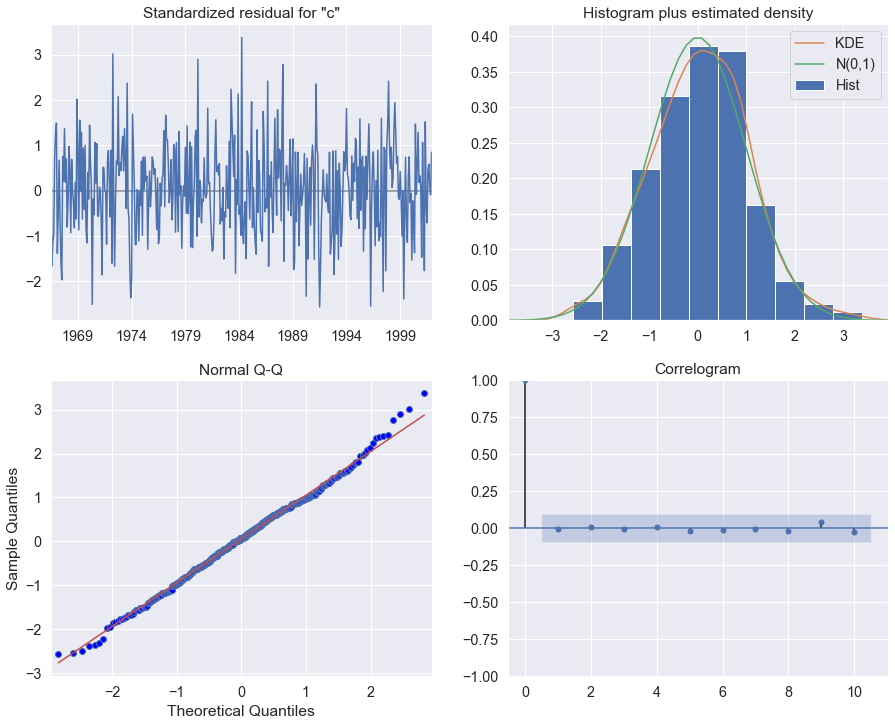

In [ ]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

### 5. Прогнозирование

#### 5.1 Прогнозирование на обучении

Начнем с сравнения прогнозируемых значений с реальными значениями временного ряда, чтобы понять насколько точны наши прогнозы.

Метод `get_prediction` у обученной модели позволяет получать прогнозы.
В коде в параметре `start` мы момент начала прогнозирования &mdash; прогнозы начинаются с января 1998 года.

Значение параметра `dynamic = False` гарантирует, что мы создаем прогнозы только на один шаг вперед. Иначе говоря, прогноз в каждой точке вычисляется с использованием полной истории ряда, вплоть до этой точки.

In [ ]:
# прогнозы на обучении
pred = model.get_prediction(start=pd.to_datetime('1998-01-01'), 
                            dynamic=False)

Сами прогозы

In [ ]:
pred_mean = pred.predicted_mean
pred_mean.head()

1998-01-01    365.037383
1998-02-01    366.059983
1998-03-01    367.100744
1998-04-01    368.505375
1998-05-01    369.066343
Freq: MS, Name: predicted_mean, dtype: float64

Предсказательные интервалы

In [ ]:
pred_ci = pred.conf_int()
pred_ci.head()

,lower co2,upper co2
1998-01-01,364.473453,365.601313
1998-02-01,365.496053,366.623913
1998-03-01,366.536814,367.664674
1998-04-01,367.941445,369.069305
1998-05-01,368.502413,369.630273


Построим график значений временного ряда CO2, чтобы увидеть наши результаты. 

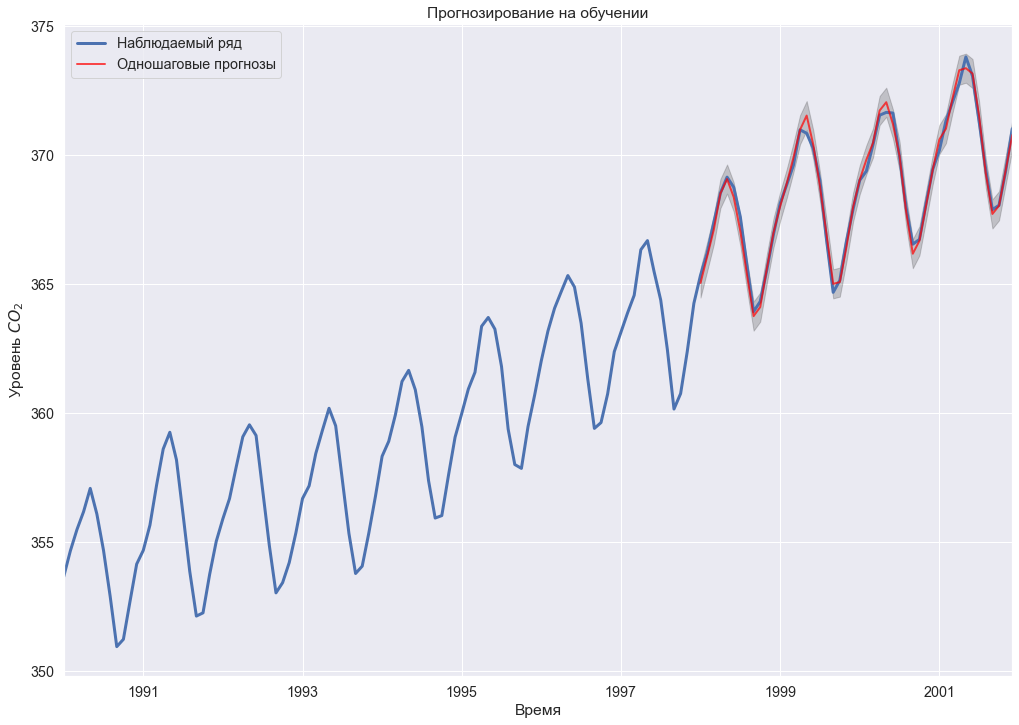

In [ ]:
# временной ряд
ax = y['1990':].plot(label='Наблюдаемый ряд', figsize=(17, 12), lw=3)

# прогнозы
pred_mean.plot(ax=ax, label='Одношаговые прогнозы', alpha=.7, 
               lw=2, color='red')
# предсказательный интервал
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                color='k', alpha=.2)

ax.set_xlabel('Время')
ax.set_ylabel('Уровень $CO_2$')
plt.title('Прогнозирование на обучении')
plt.legend()
plt.show()

Посчитаем MSE

In [ ]:
y_truth = y['1998-01-01':]
mse = ((pred_mean - y_truth) ** 2).mean()
print('MSE = {:.3f}'.format(mse))

MSE = 0.070


#### 5.2 Динамические прогнозы на обучении

В этом случае мы используем только информацию из временных рядов до определенной точки, а затем прогнозы генерируются с использованием значений из предыдущих прогнозируемых временных точек. Модель при этом обучалась на всем ряде.

В данном коде мы используем именно динамическое прогнозирование и начинаем с января 1998:

In [ ]:
pred_dynamic = model.get_prediction(start=pd.to_datetime('1998-01-01'), 
                                    dynamic=True, full_results=True)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()

Построим график. Модель обучалась на всем ряде, но для построения прогнозов используются только значения ряда из незакрашенной области. Для построения следующего прогноза используется предыдущий прогноз. Этим объясняется более широкий доверительный интервал.

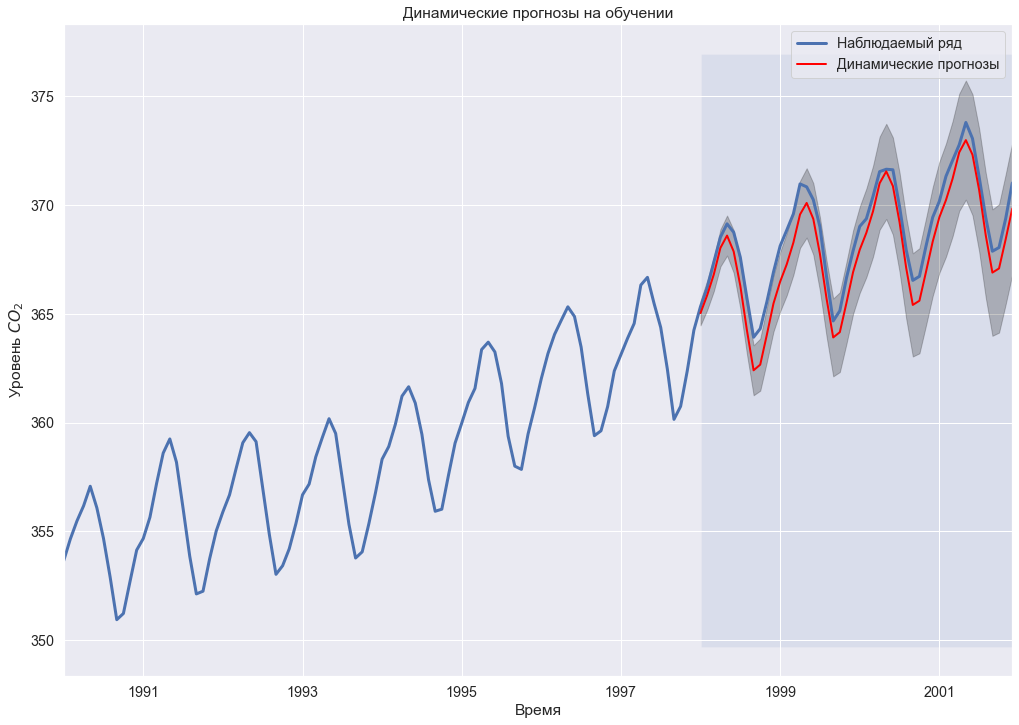

In [ ]:
# временной ряд
ax = y['1990':].plot(label='Наблюдаемый ряд', figsize=(17, 12), lw=3)

# прогнозы
pred_mean.plot(label='Динамические прогнозы', ax=ax, lw=2, color='red')
# предсказательный интервал
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], 
                pred_dynamic_ci.iloc[:, 1], 
                color='k', alpha=.25)

# область прогнозирования
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), 
                 y.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Время')
ax.set_ylabel('Уровень $CO_2$')
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()

Посчитаем MSE

In [ ]:
y_truth = y['1998-01-01':]
mse = ((pred_mean - y_truth) ** 2).mean()
print('MSE = {:.3f}'.format(mse))

MSE = 1.041


#### 5.3 Прогноз на далекое будущее (500 месяцев)

Построим прогноз на 500 месяцев вперед и построим график. На том времени мы не могли обучиться &mdash; год 2039 еще не наступил :)

In [ ]:
# прогноз на 500 шагов
pred_uc = model.get_forecast(steps=500, dynamic=True)

# сами прогнозы
pred_mean = pred_uc.predicted_mean
# предсказательные интервалы
pred_ci = pred_uc.conf_int()

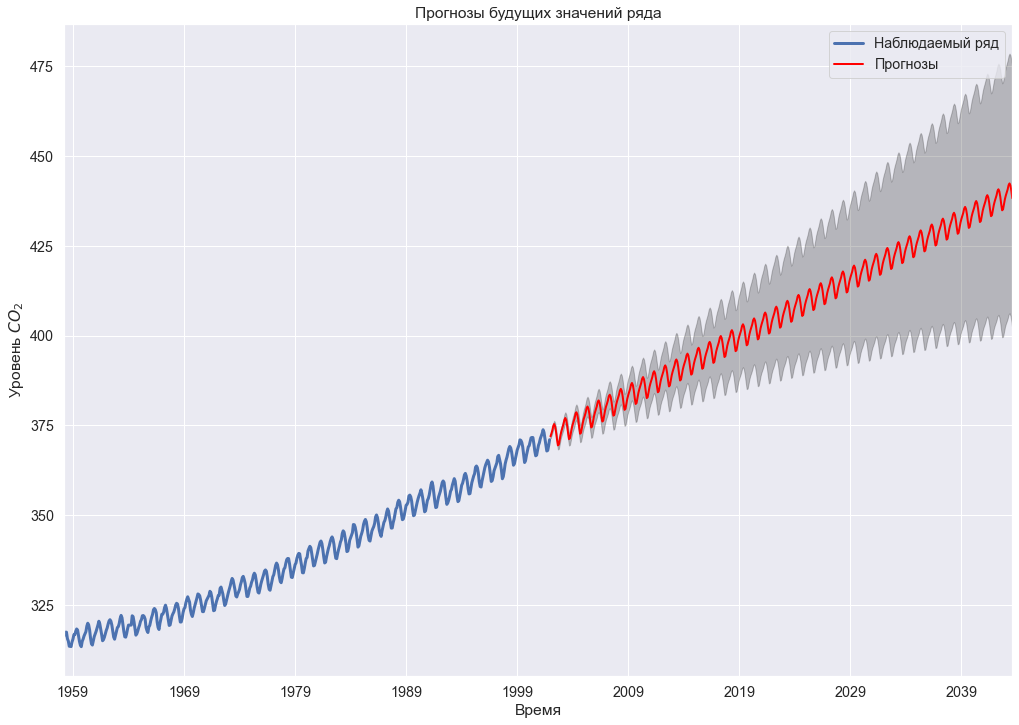

In [ ]:
# временной ряд
ax = y.plot(label='Наблюдаемый ряд', figsize=(17, 12), lw=3)
# прогнозы
pred_uc.predicted_mean.plot(ax=ax, label='Прогнозы', lw=2, color='red')
# предсказательный интервал
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                color='k', alpha=.25)

ax.set_xlabel('Время')
ax.set_ylabel('Уровень $CO_2$')
plt.title('Прогнозы будущих значений ряда')
plt.legend()
plt.show()

### 6. Auto Arima

Класс, реализующий модель Auto Arima$(p, d, q) \times (P, D, Q)_s$, а именно &mdash; перебор параметров.

`class` <a href="https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima#pmdarima.arima.auto_arima">`pmdarima.arima.auto_arima`</a>`(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)`

Параметры:

* `y` &mdash; временной ряд;
* `X` &mdash; экзогенные факторы (регрессоры);
* `start_p=2, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, start_Q=1, max_P=2, max_D=1, max_Q=2, ` &mdash; гиперпараметы для перебора;
* `m` &mdash; сезонность;
* `maxiter` &mdash; максимальное количество оценок функций.

Запустим перебор гиперпараметров.

In [ ]:
pm.auto_arima(y, trace=True,
              start_p=0,
              max_p=4,
              start_q=1,
              max_q=5,
              max_d=2, 
              start_P=3, 
              max_P=8, 
              max_D=1, 
              start_Q=1,
              max_Q=6,
              suppress_warnings=True,
              maxiter=500, m=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(3,0,1)[12] intercept   : AIC=367.739, Time=7.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1676.811, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1133.037, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1678.850, Time=0.01 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=370.588, Time=2.04 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=438.909, Time=2.55 sec
 ARIMA(0,1,1)(4,0,1)[12] intercept   : AIC=369.783, Time=16.02 sec
 ARIMA(0,1,1)(3,0,2)[12] intercept   : AIC=inf, Time=5.98 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=508.060, Time=0.76 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(0,1,1)(4,0,0)[12] intercept   : AIC=414.443, Time=5.82 sec
 ARIMA(0,1,1)(4,0,2)[12] intercept   : AIC=inf, Time=10.29 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=411.343, Time=6.52 sec
 ARIMA(1,1,1)(3,0,1)[12] intercept   : AIC=3

ARIMA(maxiter=500, order=(1, 1, 1), scoring_args={},
      seasonal_order=(3, 0, 1, 12), suppress_warnings=True,
      with_intercept=False)

Лучшей моделью оказалась `ARIMA(1,1,1)(3,0,1)[12]`.

Подставим параметры в модель SARIMAX.

In [ ]:
auto_model = sm.tsa.statespace.SARIMAX(
    y, order=(1,1,1), seasonal_order=(3, 0, 1,12),
    enforce_stationarity=False, enforce_invertibility=False,
    with_intercept=False
)

auto_model = auto_model.fit()

/Users/dvmitriylunin/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(3, 0, 1, 12)   Log Likelihood                -129.276
Date:                            Mon, 05 Apr 2021   AIC                            272.552
Time:                                    22:03:18   BIC                            301.884
Sample:                                03-01-1958   HQIC                           284.074
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2270      0.111      2.048      0.041       0.010       0.444
ma.L1         -0.5681      0.094     -6.048      0.000      -0.752      -0.384
ar.S.L12       0.9823      0.047     20.767      0.000       0.890       1.075
ar.S.L24      -0.1091      0.063     -1.733      0.083      -0.233       0.014
ar.S.L36       0.1314      0.052      2.550      0.011       0.030       0.232
ma.S.L12      -0.8681      0.038    -22.910      0.000      -0.942      -0.794
sigma2         0.0964      0.005     18.627      0.000       0.086       0.107
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.38
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Видно, что по AIC качество стало хуже.

Но посмотрим, как предсказывает модель:

In [ ]:
pred_dynamic = auto_model.get_prediction(start=pd.to_datetime('1998-01-01'), 
                                    dynamic=True, full_results=True)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()

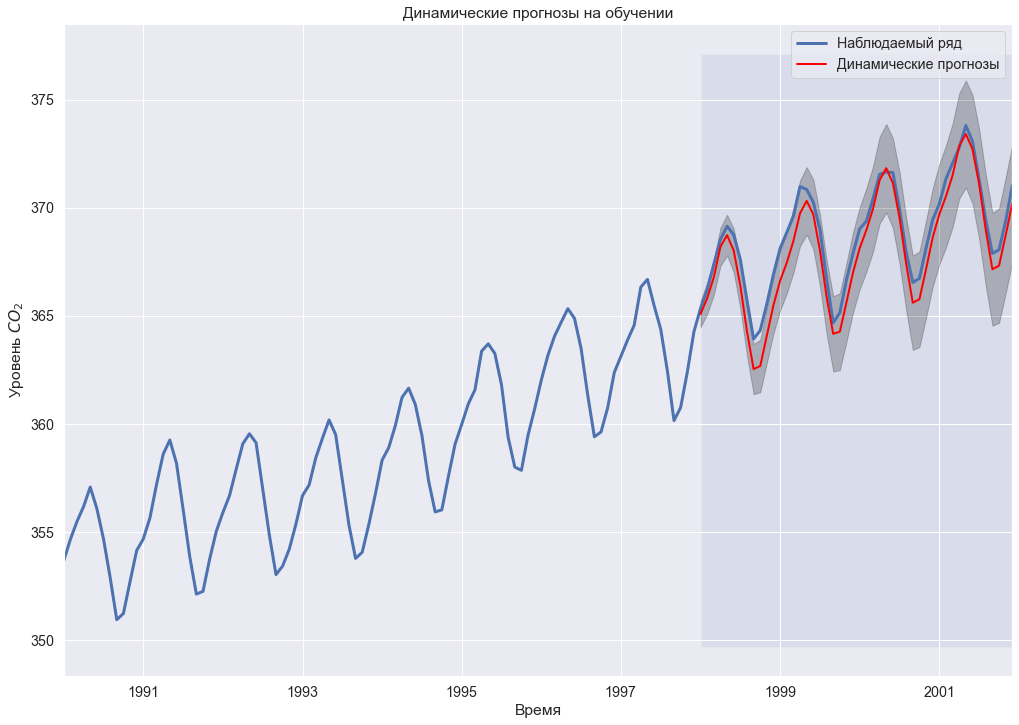

In [ ]:
# временной ряд
ax = y['1990':].plot(label='Наблюдаемый ряд', figsize=(17, 12), lw=3)

# прогнозы
pred_mean.plot(label='Динамические прогнозы', ax=ax, lw=2, color='red')
# предсказательный интервал
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], 
                pred_dynamic_ci.iloc[:, 1], 
                color='k', alpha=.25)

# область прогнозирования
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), 
                 y.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Время')
ax.set_ylabel('Уровень $CO_2$')
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()

In [ ]:
y_truth = y['1998-01-01':]
mse = ((pred_mean - y_truth) ** 2).mean()
print('MSE = {:.3f}'.format(mse))

MSE = 0.735


Как видно, качество этой модели лучше по MSE, чем модели, натюненной вручную ранее.